In [2]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

from Utils.customPipelines import *
from Utils.preprocessing import *

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import plotly.express as px

from itertools import combinations
import warnings

sns.set(font="monospace")
warnings.filterwarnings('ignore')
RANDOM_STATE = 632

# Load Data

In [3]:
# Load the dataset
file_path = 'Data/Analyst_Coverage.csv'
df = pd.read_csv(file_path)
print(df.shape)
df.sample(15)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
3180,Katmpson,2/4/2020,Thoup,NaN,not rated,8747.7,FERG LN Equity,Industrials,Capital Goods
7298,AndHeine,3/3/2020,Ma AG,5.0,buy,119.0,SOLB BB Equity,Materials,Materials
1096,JeaFarah,2/10/2020,MeSpA,3.0,neutral,107.0,DG FP Equity,Industrials,Capital Goods
1904,Mylllsop,3/9/2020,UBUBS,3.0,neutral,2000.0,AAL LN Equity,Materials,Materials
444,Jamordon,2/20/2020,J.gan,3.0,neutral,1750.0,GSK LN Equity,Health Care,"Pharmaceuticals, Biotechnology"
2995,Chaennan,2/7/2020,Crsse,5.0,outperform,178.0,DSY FP Equity,Information Technology,Software & Services
2570,Hunlcoat,3/2/2020,Intec,5.0,buy,255.0,GLEN LN Equity,Materials,Materials
1636,JonUrwin,2/28/2020,UBUBS,3.0,neutral,255.0,MUV2 GR Equity,Financials,Insurance
2013,Xavgnard,1/31/2020,Br Co,5.0,buy,18.0,ENGI FP Equity,Utilities,Utilities
4560,MarUribe,3/4/2020,UBUBS,1.0,sell,154.0,HMB SS Equity,Consumer Discretionary,Retailing


Course project 3

○ Building an unsupervised model to cluster stocks, modeling covariance/distance matrix structures

○ Understanding how companies/stocks are grouped together and investigate better ways of recategorizing peer groups

GICS industry code (8 digits) consists of:

11 sectors, 24 industry groups, 69 industries and 158 sub-industries

(sector | industry group | industry | sub-industry)

# Data Preprocessing
- Check for NA values
- Check for duplicates
- Standardise row types


In [4]:
# Drop rows with missing data (Assuming missing RATING means not properly covered by analyst)
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()
# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()
# Check Types
print(df.info())

Missing values per column:
 ANALYST                       0
DATE                          0
BROKER                        0
RATING                      239
RECOMMENDATION                0
TARGET_PRICE                  0
BBTICKER                      0
GICS_SECTOR_NAME              0
GICS_INDUSTRY_GROUP_NAME      0
dtype: int64

Number of duplicate rows: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8676 entries, 0 to 8675
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ANALYST                   8676 non-null   object 
 1   DATE                      8676 non-null   object 
 2   BROKER                    8676 non-null   object 
 3   RATING                    8437 non-null   float64
 4   RECOMMENDATION            8676 non-null   object 
 5   TARGET_PRICE              8676 non-null   float64
 6   BBTICKER                  8676 non-null   object 
 7   GICS_SECTOR_NAME          8676 non-

We will impute the NaN values for ratings with the mean ratings per industry

In [5]:
df_mean_rating = df[["GICS_SECTOR_NAME", "RATING"]].dropna().groupby(["GICS_SECTOR_NAME"], as_index=False).mean()
df_imputed = df[df["RATING"].isna()].copy()
df_imputed = df_imputed.drop(columns=["RATING"]).merge(df_mean_rating, on=["GICS_SECTOR_NAME"])
df_clean = pd.concat([df.dropna(), df_imputed])

print(df_clean.shape)
df_clean.sample(7)

(8676, 9)


,ANALYST,DATE,BROKER,RATING,RECOMMENDATION,TARGET_PRICE,BBTICKER,GICS_SECTOR_NAME,GICS_INDUSTRY_GROUP_NAME
2126,Johholtz,2/28/2020,MoInc,5.0,buy,5.9,BBVA SM Equity,Financials,Banks
2407,ChrKorth,12/2/2019,HSSBC,5.0,buy,39.0,DPW GR Equity,Industrials,Transportation
6474,Marshney,3/5/2020,Crsse,3.0,neutral,2160.0,SVT LN Equity,Utilities,Utilities
1555,Osciguez,10/4/2019,Baell,5.0,buy,145.0,EL FP Equity,Consumer Discretionary,Consumer Durables & Apparel
8210,Marlding,2/26/2020,RBets,5.0,top pick,1800.0,WEIR LN Equity,Industrials,Capital Goods
8568,Nicmpsey,3/3/2020,Baays,3.0,equalweight,8.5,SESG FP Equity,Communication Services,Media & Entertainment
2489,Rosanjit,2/17/2020,Deank,5.0,buy,17.0,ORA FP Equity,Communication Services,Telecommunication Services


# Analyze Data


## 1. Which company has the higher analyst coverage?

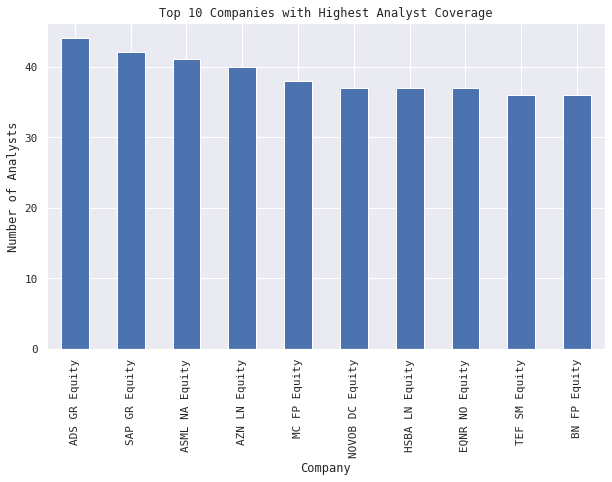

The company with the highest analyst coverage is 'ADS GR Equity' with 44 analysts covering it.


In [5]:
# Calculate the analyst coverage for each company
df_coverage = df_clean[['BBTICKER', 'ANALYST']].copy()
df_coverage = df_coverage.drop_duplicates()
company_coverage = df_coverage['BBTICKER'].value_counts()

# Plot the top 10 companies with the highest analyst coverage
top_10_company_coverage = company_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_company_coverage.plot(kind='bar')
plt.title('Top 10 Companies with Highest Analyst Coverage')
plt.xlabel('Company')
plt.ylabel('Number of Analysts')
plt.show()

# Find the company with the highest analyst coverage
most_covered_company = company_coverage.idxmax()
most_covered_company_coverage = company_coverage.max()

print(f"The company with the highest analyst coverage is '{most_covered_company}' with {most_covered_company_coverage} analysts covering it.")


## 2. Which analyst covers the most companies?

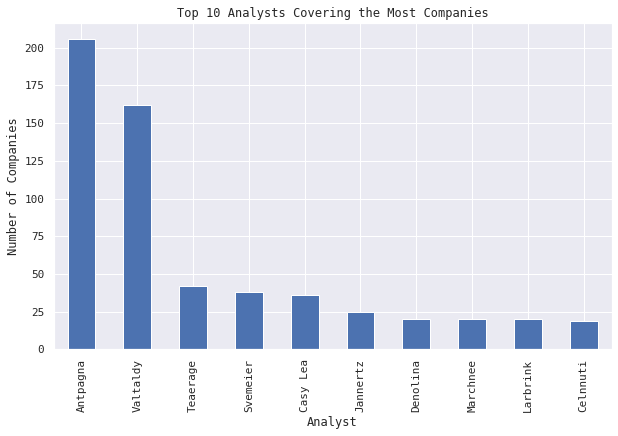

The analyst who covers the most companies is 'Antpagna' covering 206 different companies.


In [6]:
# Calculate the number of companies each analyst covers
# analyst_coverage = df.groupby('ANALYST')['BBTICKER'].nunique()
analyst_coverage = df_coverage['ANALYST'].value_counts()

# Plot the top 10 analysts covering the most companies
# top_10_analyst_coverage = analyst_coverage.sort_values(ascending=False).head(10)
top_10_analyst_coverage = analyst_coverage.head(10)

plt.figure(figsize=(10, 6))
top_10_analyst_coverage.plot(kind='bar')

plt.title('Top 10 Analysts Covering the Most Companies')
plt.xlabel('Analyst')
plt.ylabel('Number of Companies')
plt.show()

# Find the analyst covering the most companies
most_companies_analyst = analyst_coverage.idxmax()
most_companies_coverage = analyst_coverage.max()

print(f"The analyst who covers the most companies is '{most_companies_analyst}' covering {most_companies_coverage} different companies.")


## 3. Similarity Matrix
https://medium.com/analytics-vidhya/similarity-measures-for-categorical-data-d83a1812bbe9

Based on how analysts organize themselves into covering companies,
### a. Could you model the similarity or conversely, the distance matrix between the companies based on this analyst co-coverage


In [7]:
categorical_features_ordinal = []
categorical_features_one_hot = ['GICS_SECTOR_NAME', 'GICS_INDUSTRY_GROUP_NAME', 'BROKER']
numerical_features = ['RATING']
clean_pipeline = get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)

# We only want to observe analyst 'Antpagna'
# We also clean the dataset 
## -- Categorical features: One_hot/Ordinal encoding 

df_analyst_antpaga = df_clean[df_clean["ANALYST"] == "Antpagna"].copy()

# Remove duplicates
df_analyst_antpaga = df_analyst_antpaga.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_company_antaga = df_analyst_antpaga[df_analyst_antpaga["BBTICKER"].isin(df_analyst_antpaga['BBTICKER'].tolist())]
df_preprocessed = clean_pipeline.fit_transform(df_company_antaga.copy())
cols = df_analyst_antpaga["BBTICKER"].tolist().copy()
df_preprocessed.sample(7)

,GICS_SECTOR_NAME_Communication Services,GICS_SECTOR_NAME_Consumer Discretionary,GICS_SECTOR_NAME_Consumer Staples,GICS_SECTOR_NAME_Energy,GICS_SECTOR_NAME_Financials,GICS_SECTOR_NAME_Industrials,GICS_SECTOR_NAME_Information Technology,GICS_SECTOR_NAME_Materials,GICS_SECTOR_NAME_Real Estate,GICS_SECTOR_NAME_Utilities,...,GICS_INDUSTRY_GROUP_NAME_Media & Entertainment,GICS_INDUSTRY_GROUP_NAME_Real Estate,GICS_INDUSTRY_GROUP_NAME_Retailing,GICS_INDUSTRY_GROUP_NAME_Semiconductors & Semiconductor,GICS_INDUSTRY_GROUP_NAME_Software & Services,GICS_INDUSTRY_GROUP_NAME_Technology Hardware & Equipmen,GICS_INDUSTRY_GROUP_NAME_Telecommunication Services,GICS_INDUSTRY_GROUP_NAME_Utilities,BROKER_ISEVA,RATING
204,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
159,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,3.0
65,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
182,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
155,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.0
157,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5.0
82,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0


Shape of the similarity matrix: (206, 206)


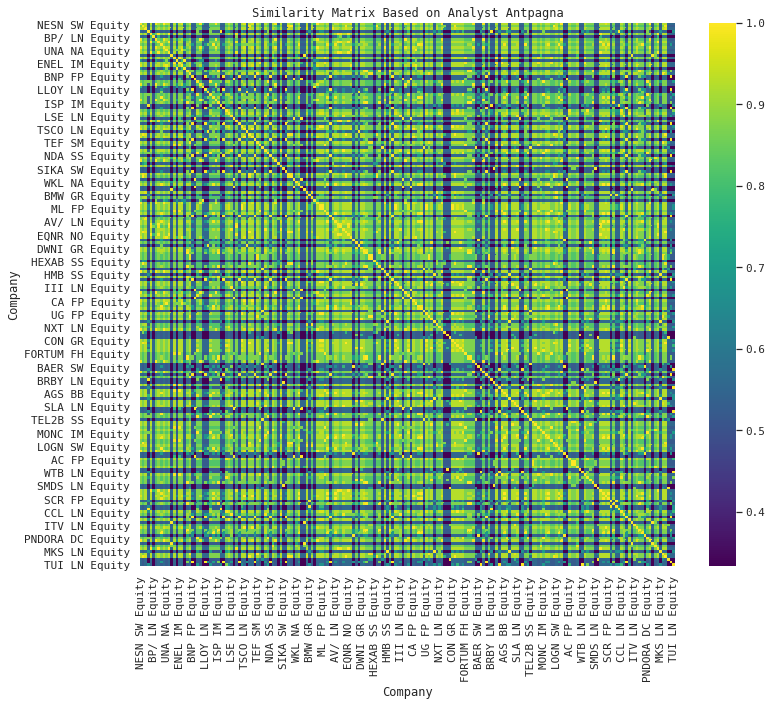

In [8]:
df_preprocessed_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed, df_preprocessed),  
                                   index = cols, columns = cols)

print("Shape of the similarity matrix:", df_preprocessed_sim.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst Antpagna')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


### b. How would the results change if you were to restrict the dataset to only analysts having companies covered within 1s.d. of the distribution found in Qn. 2?

(1974,)
The analyst with the most coverage after filtering: Verajova

Shape of the similarity matrix: (10, 10)


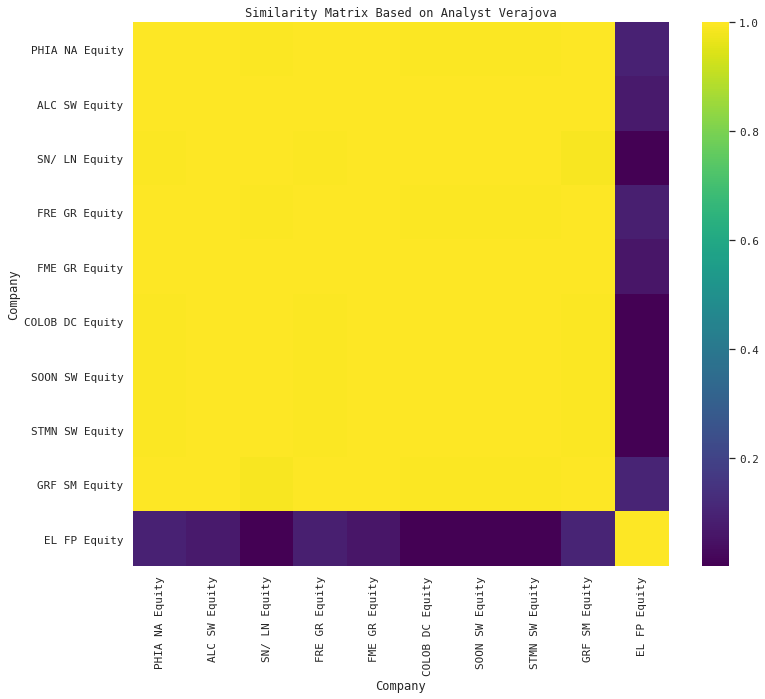

In [17]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index
filtered_df = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].copy()

# Now, we find the analyst with the most coverage
filtered_df_analyst_coverage = filtered_df['ANALYST'].value_counts()
filtered_highest_analyst = filtered_df_analyst_coverage.head(1).index[0]
print(filtered_df_analyst_coverage.shape)
print("The analyst with the most coverage after filtering: " + filtered_highest_analyst)
print()

# Then, find the rows covered by analyst
df_analyst = df_clean[df_clean["ANALYST"] == filtered_highest_analyst].copy()
# Remove duplicates
df_analyst = df_analyst.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_preprocessed = clean_pipeline.fit_transform(df_analyst.copy())
cols = df_analyst["BBTICKER"].tolist().copy()

df_preprocessed_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed, df_preprocessed),  
                                   index = cols, columns = cols)

print("Shape of the similarity matrix:", df_preprocessed_sim.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst ' + filtered_highest_analyst)
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

Shape of the filtered similarity matrix: (360, 360)


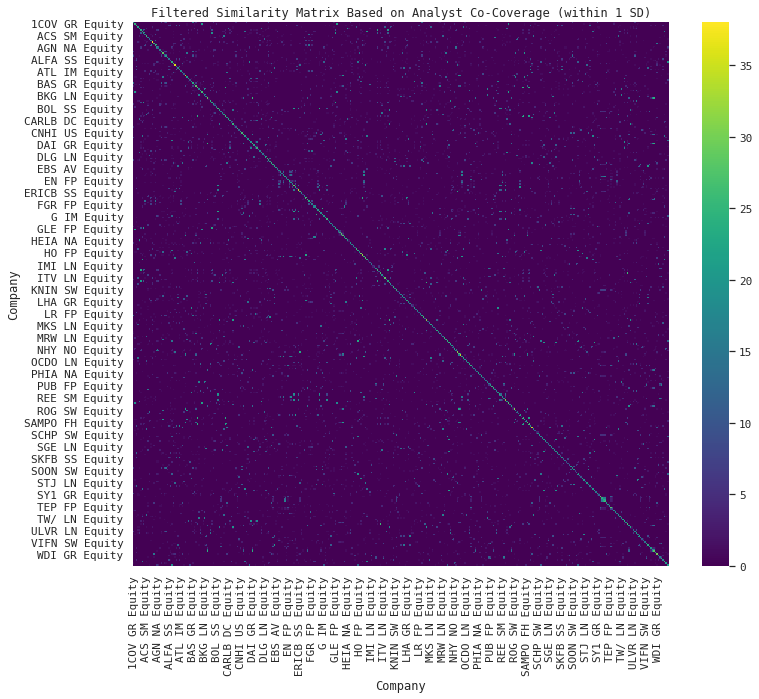

In [10]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage)].index

# Filter the dataframe to only include the filtered analysts
filtered_df = df[df['ANALYST'].isin(filtered_analysts)]

# Create a pivot table for the filtered analysts
filtered_pivot_table = filtered_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the filtered data
filtered_similarity_matrix = np.dot(filtered_pivot_table.T, filtered_pivot_table)

# Convert to DataFrame for better visualization
filtered_similarity_df = pd.DataFrame(filtered_similarity_matrix, index=filtered_pivot_table.columns, columns=filtered_pivot_table.columns)

# Print the shape of the filtered similarity matrix
print("Shape of the filtered similarity matrix:", filtered_similarity_df.shape)

# Plot the filtered similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_similarity_df, cmap='viridis')
plt.title('Filtered Similarity Matrix Based on Analyst Co-Coverage (within 1 SD)')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


### c. If further restricted to a smaller subset?

For this example, let's further restrict the dataset by only choosing analysts within 0.25 s.d of the mean 

The analyst with the most coverage after filtering: JosOcina

Shape of the similarity matrix: (5, 5)


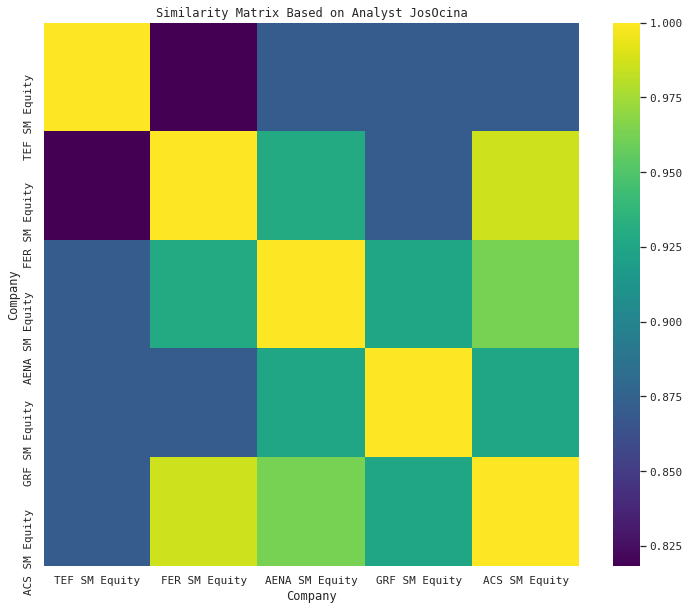

In [11]:
# Calculate the mean and standard deviation of the number of companies covered by each analyst
mean_coverage = analyst_coverage.mean()
std_dev_coverage = analyst_coverage.std()

# Filter analysts who cover companies within 1 standard deviation of the mean
filtered_analysts = analyst_coverage[(analyst_coverage >= mean_coverage - std_dev_coverage * 0.25) & 
                                     (analyst_coverage <= mean_coverage + std_dev_coverage * 0.25)].index
filtered_df = df_clean[df_clean['ANALYST'].isin(filtered_analysts)].copy()

# Now, we find the analyst with the most coverage
filtered_df_analyst_coverage = filtered_df['ANALYST'].value_counts()
filtered_highest_analyst = filtered_df_analyst_coverage.head(1).index[0]
print("The analyst with the most coverage after filtering: " + filtered_highest_analyst)
print()

# Then, find the rows covered by analyst
df_analyst = df_clean[df_clean["ANALYST"] == filtered_highest_analyst].copy()
# Remove duplicates
df_analyst = df_analyst.drop_duplicates(subset=['BBTICKER']).reset_index(drop=True)

df_preprocessed = clean_pipeline.fit_transform(df_analyst.copy())
cols = df_analyst["BBTICKER"].tolist().copy()

df_preprocessed_sim = pd.DataFrame(data = cosine_similarity(df_preprocessed, df_preprocessed),  
                                   index = cols, columns = cols)

print("Shape of the similarity matrix:", df_preprocessed_sim.shape)

# Plot the similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df_preprocessed_sim, cmap='viridis')
plt.title('Similarity Matrix Based on Analyst ' + filtered_highest_analyst)
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

Shape of the selected similarity matrix: (27, 27)


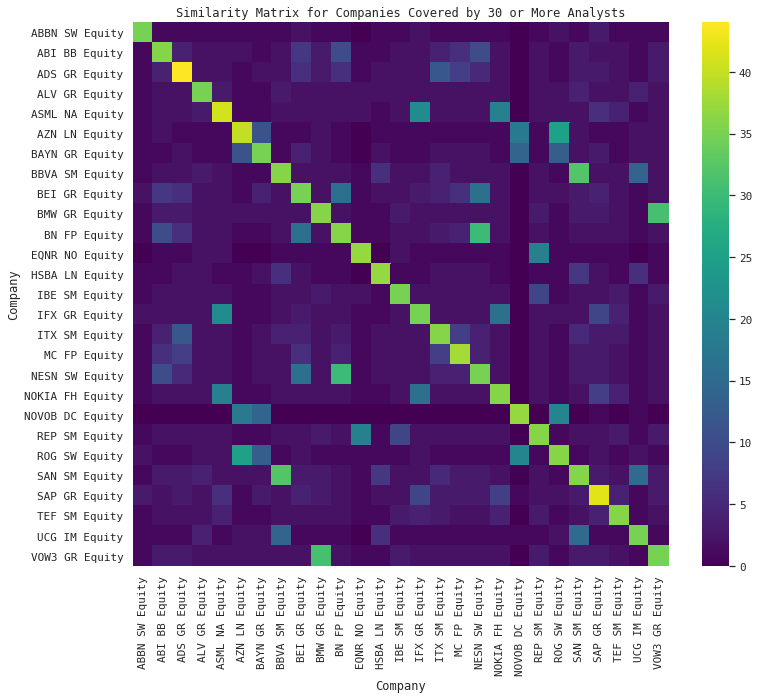

In [12]:
# Filter companies covered by 35 or more analysts
company_coverage = df['BBTICKER'].value_counts()
selected_companies = company_coverage[company_coverage >= 35].index

# Filter the dataframe to only include the selected companies
selected_df = df[df['BBTICKER'].isin(selected_companies)]

# Create a pivot table for the selected companies
selected_pivot_table = selected_df.pivot_table(index='ANALYST', columns='BBTICKER', aggfunc='size', fill_value=0)

# Compute the similarity matrix for the selected companies
selected_similarity_matrix = np.dot(selected_pivot_table.T, selected_pivot_table)

# Convert to DataFrame for better visualization
selected_similarity_df = pd.DataFrame(selected_similarity_matrix, index=selected_pivot_table.columns, columns=selected_pivot_table.columns)

# Print the shape of the selected similarity matrix
print("Shape of the selected similarity matrix:", selected_similarity_df.shape)

# Plot the selected similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(selected_similarity_df, cmap='viridis')
plt.title('Similarity Matrix for Companies Covered by 30 or More Analysts')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()


# 4. Which sectors are the most heterogenous? (Look at the clusters formed by industry groups per sector – use t-SNE to visualize)

In [38]:
sectors = df_clean["GICS_SECTOR_NAME"].unique().tolist()

categorical_features_ordinal = []
categorical_features_one_hot = ['ANALYST', 'BROKER', 'BBTICKER']
numerical_features = ['RATING', 'TARGET_PRICE']

clean_pipeline = Pipeline([
    ('clean_pipeline', get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)),
    ('standard_scaler', StandardScaler()),
    ('PCA', PCA(n_components=5)),
    ('tsne', TSNE(n_components=2, perplexity=195, random_state=RANDOM_STATE))
])

for s in sectors:
    df_by_sector = df_clean[df_clean["GICS_SECTOR_NAME"] == s].copy()
    cols = df_by_sector['GICS_INDUSTRY_GROUP_NAME'].tolist()

    X_tsne = clean_pipeline.fit_transform(df_by_sector.copy())

    print(clean_pipeline['tsne'].kl_divergence_)

    fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=cols)
    fig.update_layout(
        title="t-SNE visualization of Sector " + s,
        xaxis_title="First t-SNE",
        yaxis_title="Second t-SNE",
    )
    fig.show()



0.3847692608833313


0.38830000162124634


0.5895623564720154


0.2837529480457306


0.4720776677131653


0.09727010130882263


0.6232971549034119


0.2826192378997803


0.4475756883621216


0.3453861474990845


0.020268594846129417


In [35]:
perplexity = np.arange(50, 200, 5)
divergence = []

for i in perplexity:
    clean_pipeline = Pipeline([
        ('clean_pipeline', get_pipeline_clean_encode_only(categorical_features_one_hot, categorical_features_ordinal, numerical_features)),
        ('standard_scaler', StandardScaler()),
        ('PCA', PCA(n_components=5)),
        ('tsne', TSNE(n_components=2, perplexity=i, random_state=RANDOM_STATE))
    ])

    df_by_sector = df_clean[df_clean["GICS_SECTOR_NAME"] == "Consumer Discretionary"].copy()

    reduced = clean_pipeline.fit_transform(df_by_sector.copy())
    divergence.append(clean_pipeline['tsne'].kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

# 5. Similarly, which sectors are the most homogenous?

# 6. What type of companies tend to be outliers in terms of the clusters?

# 7. Feel free to explore and provide deeper insights in the structure of the clusters/network as part of the outputs.